Philippe Joly 28-09-24

# Rope Binary Segmentation

Implementation of various methods to segment a rope from its background and turn it into a binary segmentation

In [ ]:
i=2

## Setup

In [2]:
import matplotlib.pyplot as plt
import numpy as np

import skimage.io as io
from skimage.filters import threshold_otsu, sobel
from skimage.color import rgb2gray
from skimage.segmentation import watershed
from skimage.feature import canny

import cv2
from scipy import ndimage

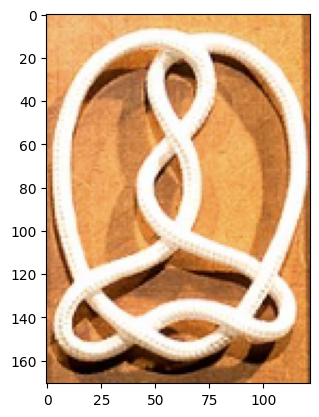

In [22]:
img_og =  io.imread(f'./examples/{i}_knot.png')[...,:3]      # Gray image, rgb images need pre-conversion
img_gray = rgb2gray(img_og)
plt.imshow(img_og)

In [4]:
def blur(img, k_size, blur_size):
    kernel = np.ones((k_size,k_size))

    closing = ndimage.binary_closing(img, structure=kernel)
    opening = ndimage.binary_opening(closing, structure=kernel)

    result = ndimage.median_filter(opening, size=blur_size)

    return result

## Otsu Binary Segmentation

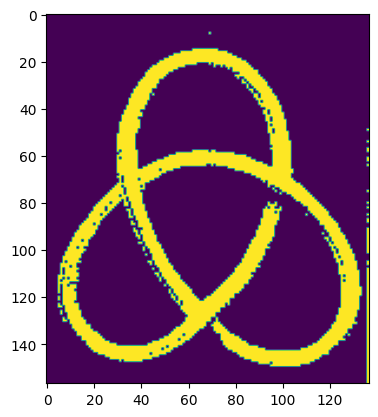

In [5]:
Otsu_Threshold = threshold_otsu(img_gray) 
t = Otsu_Threshold  
bw_otsu = img_gray > t

count_0 = np.sum(bw_otsu == 0)
count_1 = np.sum(bw_otsu == 1)
most_frequent = 0 if count_0 > count_1 else 1

bw_otsu2 = np.zeros_like(bw_otsu)
bw_otsu2[bw_otsu == most_frequent] = 0
bw_otsu2[bw_otsu != most_frequent] = 1

bw_otsu = bw_otsu2
plt.imshow(bw_otsu)

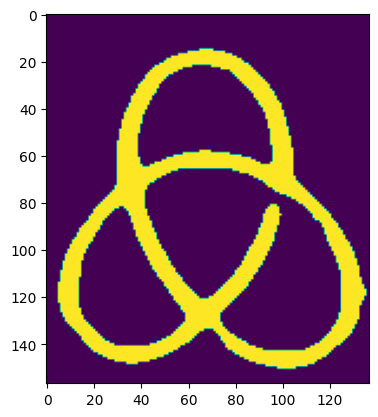

In [6]:
bw_otsu = blur(bw_otsu, 3, 6)
plt.imshow(bw_otsu)

## Region-Based Segmentation

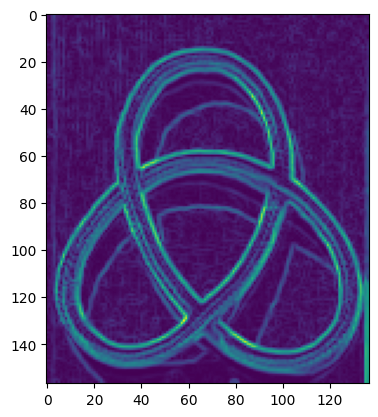

In [7]:
elevation_map_rb = sobel(img_gray)
plt.imshow(elevation_map_rb)

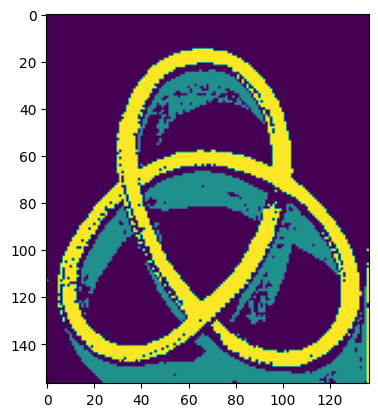

In [8]:
markers_rb = np.zeros_like(img_gray)
markers_rb[img_gray<30/255]=1
markers_rb[img_gray>150/255]=2
markers_rb = markers_rb.astype(np.int32)
plt.imshow(markers_rb)

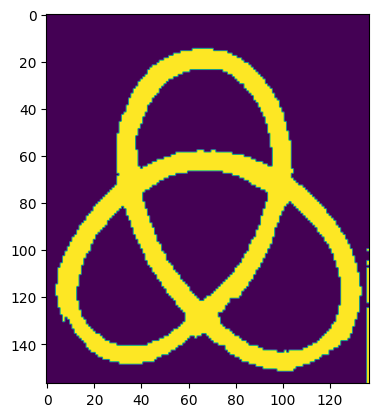

In [9]:
bw_rb = watershed(elevation_map_rb, markers_rb)-1
plt.imshow(bw_rb)

## Color-Based K-Means Segmentation

In [10]:
pixels = img_og.reshape((-1,3)).astype(np.float32)
pixels.shape

(21509, 3)

In [11]:
criteria = (cv2.TERM_CRITERIA_EPS+cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
k=2
_, lbls, centers = cv2.kmeans(pixels, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
centers = np.uint8(centers)
centers

array([[222, 206, 187],
       [117,  66,  21]], dtype=uint8)

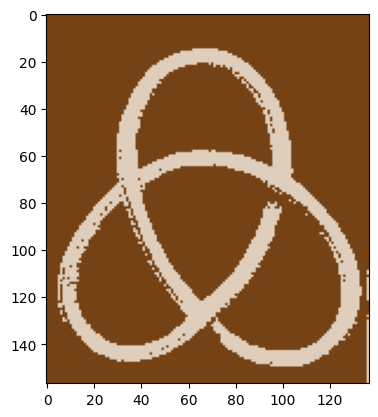

In [12]:
segment_img_k = centers[lbls.flatten()]
segment_img_k = segment_img_k.reshape(img_og.shape)
plt.imshow(segment_img_k)

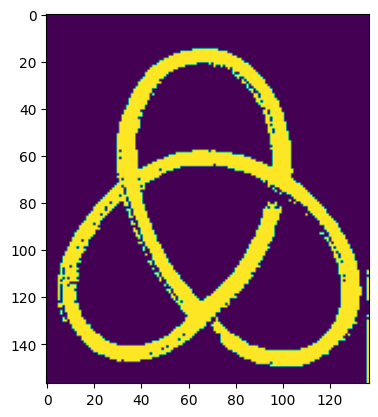

In [13]:
bw_k = lbls.reshape(img_og[:,:,0].shape)

count_0 = np.sum(bw_k == 0)
count_1 = np.sum(bw_k == 1)
most_frequent = 0 if count_0 > count_1 else 1

bw_k2 = np.zeros_like(bw_k)
bw_k2[bw_k == most_frequent] = 0
bw_k2[bw_k != most_frequent] = 1

if most_frequent == 1:
    bgd = centers[0]
    centers[0] = centers[1]
    centers[1] = bgd

stds = []
for i, cluster in enumerate(centers):
    pts = img_og[bw_k == i]
    stds.append(np.array([np.std(pts[:,0].flatten()),np.std(pts[:,1]),np.std(pts[:,2])]))

# bw_k = blur(bw_k2, 2, 2)
bw_k = bw_k2
plt.imshow(bw_k)

### Combination with Sobel Edge Detection

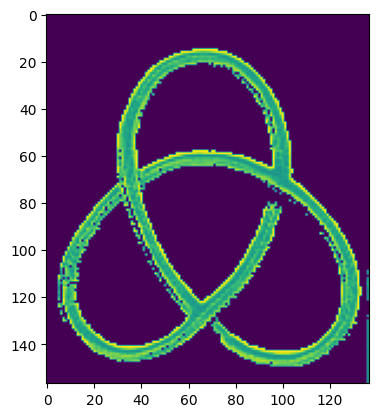

In [14]:
sobel_x = cv2.Sobel(img_gray, cv2.CV_64F, 1, 0, ksize=3)  # X gradient
sobel_y = cv2.Sobel(img_gray, cv2.CV_64F, 0, 1, ksize=3)  # Y gradient
sobel_mag = np.sqrt(sobel_x ** 2 + sobel_y ** 2)  # Edge magnitude
sobel_mag = cv2.normalize(sobel_mag, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

mask = (bw_k == 1).astype(np.uint8)

# Apply the mask to the Sobel edges to keep edges only in the object region
masked_sobel = cv2.bitwise_and(sobel_mag, sobel_mag, mask=mask)

# Optional: Combine K-means mask with Sobel for sharper edges
combined_result = cv2.addWeighted(masked_sobel, 1.0, mask*255, 0.5, 0)
plt.imshow(combined_result)


## Color-Based K-means and Region Growing

In [15]:
def is_valid_pixel(x, y, image_shape):
    return 0 <= x < image_shape[0] and 0 <= y < image_shape[1]

In [16]:
def region_growing(image, seed, threshold):
    h, w = image.shape[:2]
    segmented = np.zeros((h, w), dtype=np.uint8)  # Segmented region mask
    visited = np.zeros((h, w), dtype=np.uint8)    # Visited pixel mask
    seed_value = image[seed]
    
    # List of 8 connected neighbors (N, S, E, W, NE, NW, SE, SW)
    neighbors = [(-1, 0), (1, 0), (0, -1), (0, 1), (-1, -1), (-1, 1), (1, -1), (1, 1)]
    
    # Stack to store pixels to check
    stack = [seed]
    visited[seed] = 1
    segmented[seed] = 255  # Mark the seed pixel in the segmented mask
    
    while len(stack) > 0:
        current_pixel = stack.pop()
        x, y = current_pixel
        
        # Check the 8-connected neighbors
        for dx, dy in neighbors:
            nx, ny = x + dx, y + dy
            if is_valid_pixel(nx, ny, image.shape[:2]) and not visited[nx, ny]:
                # Check the similarity criterion (intensity difference in this case)
                if (np.abs(image[nx, ny] - seed_value) < threshold).any():
                    segmented[nx, ny] = 255  # Add pixel to the region
                    stack.append((nx, ny))  # Add to stack for further exploration
                visited[nx, ny] = 1  # Mark as visited
                
    return segmented

In [17]:
dis = np.linalg.norm(img_og.astype(np.int16)- centers[1], axis=-1)
min_idx = np.unravel_index(np.argmin(dis), dis.shape)

bw_rg = region_growing(img_og, min_idx, 1*stds[1])

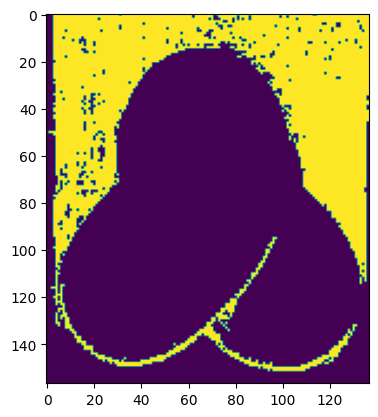

In [18]:
plt.imshow(bw_rg)

## Results

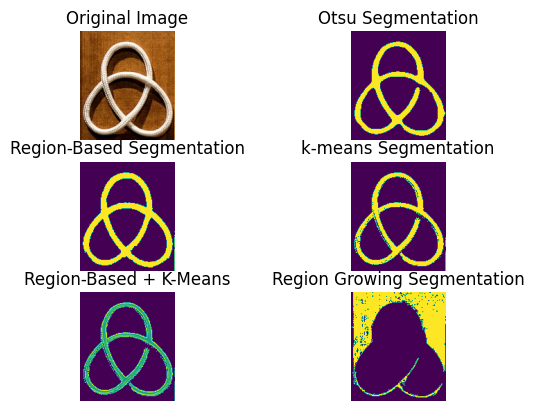

In [19]:
fig, ax = plt.subplots(3,2)
ax1, ax2, ax3, ax4, ax5, ax6 = ax.ravel()

ax1.imshow(img_og)
ax1.set_title('Original Image')
ax1.axis('off')

ax2.imshow(bw_otsu)
ax2.set_title('Otsu Segmentation')
ax2.axis('off')

ax3.imshow(bw_rb)
ax3.set_title('Region-Based Segmentation')
ax3.axis('off')

ax4.imshow(bw_k)
ax4.set_title('k-means Segmentation')
ax4.axis('off')

ax5.imshow(combined_result)
ax5.set_title('Region-Based + K-Means')
ax5.axis('off')

ax6.imshow(bw_rg)
ax6.set_title('Region Growing Segmentation')
ax6.axis('off')
plt.show()